1) Read in all files
2) See how many 0's, 1's
3) Analyze file (see the average length) 

In [9]:
import os
import pathlib

data_path = os.path.join(os.getcwd(),"data")
print(data_path)
for dirName, subdirList, fileList in os.walk(data_path):
    zeros = [f for f in fileList if f.split(".csv")[0].split("_",2)[2] == '0']
    ones = [f for f in fileList if f.split(".csv")[0].split("_",2)[2] == '1']
print(f"Zeros: {len(zeros)}\nOnes: {len(ones)}")

import pandas as pd

all_files = zeros + ones
file_lengths = []
for f in all_files:
    df = pd.read_csv(os.path.join(data_path,f))
    file_lengths.append(df.shape[0])
pd.Series(file_lengths).describe()

c:\Users\m.litton_local\ca_disengagement\ca_disengagement\data
Zeros: 103
Ones: 116


count     219.000000
mean      494.050228
std       119.566542
min       251.000000
25%       437.000000
50%       470.000000
75%       567.500000
max      1002.000000
dtype: float64

4) For each file, take 5 seconds before and 1 second after the event of interest (sampling every 0.5 seconds)

In [10]:
sample_interval = 0.5
seconds_before = 5
seconds_after = 1

all_seqs = []
for file in all_files:
    df = pd.read_csv(os.path.join(data_path,file),index_col=0)

    #The "event of interest" is:
    #   For '1' paths, when the minimum distance is (this will be during the lane change)
    #   For '0' paths, when the minimum distance once the adversary gets in front of the ego is
    
    
    
    df_moving = df[25:]
    max_accel = df_moving['adv_accel_y'].max()
    max_accel_idx = df_moving['adv_accel_y'].idxmax()

    """
    if file in zeros:
        in_front = df[df['angle'].abs() < 5]
        if(in_front.shape[0]>0):
            min_dist = in_front['distance'].min()
            min_dist_idx = in_front['distance'].idxmin()
        else:
            print(f"the file: ({file}) is in zeros but no time in front")
    if file in ones:
        min_dist = df['distance'].min()
        min_dist_idx = df['distance'].idxmin()
    """
    start_idx = max_accel_idx - seconds_before * (2*sample_interval/0.05)
    stop_idx = max_accel_idx + seconds_after * (2*sample_interval/0.05)

    indices_to_sample = []
    for x in range(int(start_idx),int(stop_idx+1),int(sample_interval/0.05)): indices_to_sample.append(x)

    columns_of_interest = ['distance','angle',
        'ego_vel_x','ego_vel_y','ego_vel_z','ego_accel_x','ego_accel_y','ego_accel_z','ego_ang_vel_x','ego_ang_vel_y','ego_ang_vel_z',
        'adv_vel_x','adv_vel_y','adv_vel_z','adv_accel_x','adv_accel_y','adv_accel_z','adv_ang_vel_x','adv_ang_vel_y','adv_ang_vel_z']
    try:
        rows_of_interest = df.loc[indices_to_sample,columns_of_interest]
    except:
        print(f"bad keys in file {file}")
        print(indices_to_sample)
        continue
    one_seq = []
    for index, rows in rows_of_interest.iterrows():
        for elem in rows:
            one_seq.append(elem)
    one_seq.append(file.split(".csv")[0].split("_",2)[2])
    all_seqs.append(one_seq)

full_df = pd.DataFrame(all_seqs, columns=(columns_of_interest * 13 + ['class']))
full_df.to_csv(os.path.join(os.getcwd(),"classifier_data\\labeled_data.csv"),index=None)
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Columns: 261 entries, distance to class
dtypes: float64(260), object(1)
memory usage: 446.7+ KB


5) Generate Train/Test Files

In [11]:
from sklearn.model_selection import train_test_split
x = full_df.iloc[:,:-1]
y = full_df.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.33)
train = x_train.assign(Class=y_train)
test = x_test.assign(Class=y_test)
train.to_csv(os.path.join(os.getcwd(),"classifier_data\\train_file.csv"),index=None)
test.to_csv(os.path.join(os.getcwd(),"classifier_data\\test_file.csv"),index=None)

In [12]:
x_train.head()

,distance,angle,ego_vel_x,ego_vel_y,ego_vel_z,ego_accel_x,ego_accel_y,ego_accel_z,ego_ang_vel_x,ego_ang_vel_y,...,ego_ang_vel_z,adv_vel_x,adv_vel_y,adv_vel_z,adv_accel_x,adv_accel_y,adv_accel_z,adv_ang_vel_x,adv_ang_vel_y,adv_ang_vel_z
140,1.388446,-121.675580,2.172591,-0.006259,0.001868,-0.854416,-0.032512,-0.013376,-0.023022,-0.353531,...,-0.859916,2.681756,0.711327,0.030883,-0.103002,-0.079619,0.000164,0.001881,-0.137958,3.183167
134,0.413275,-139.795001,2.145585,-0.006015,0.000485,1.128025,-0.044704,0.011795,0.088501,0.386987,...,-0.919316,3.028599,0.797797,0.017732,-0.227585,-0.047946,0.017132,0.005309,-0.145483,4.325610
185,0.401628,-102.734077,2.074257,-0.005956,-0.000302,0.250907,-0.042951,0.008790,0.032592,0.061778,...,-0.948713,3.019130,0.791360,0.034749,-0.167751,-0.022473,-0.003272,-0.005818,-0.152223,4.300009
103,0.399142,-137.265104,2.137084,-0.004024,-0.000548,-1.049290,0.045356,-0.011273,-0.093227,-0.382430,...,9.499618,2.415219,0.410821,0.016840,0.043836,0.155589,-0.044429,3.117825,-0.069184,4.745868
206,0.407219,-57.548714,2.228659,-0.006720,0.020297,0.193205,-0.036909,-0.002122,0.057794,0.006035,...,-0.911618,2.707151,0.721859,0.058602,-0.041733,-0.027505,-0.001057,-0.072243,-0.065572,4.059795


In [13]:
from sklearn.metrics import accuracy_score,r2_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

RF = RandomForestClassifier()
RF.fit(x_train,y_train)
RF.score(x_test,y_test)

0.9726027397260274

[(81, 'angle', 0.06), (101, 'angle', 0.05), (220, 'distance', 0.05), (152, 'adv_vel_y', 0.05), (141, 'angle', 0.05), (191, 'adv_vel_x', 0.04530764807360552), (51, 'adv_vel_x', 0.04), (200, 'distance', 0.04), (160, 'distance', 0.04), (259, 'adv_ang_vel_z', 0.03), (201, 'angle', 0.03), (120, 'distance', 0.03), (251, 'adv_vel_x', 0.03), (71, 'adv_vel_x', 0.03), (41, 'angle', 0.03), (21, 'angle', 0.03), (91, 'adv_vel_x', 0.02), (231, 'adv_vel_x', 0.02), (132, 'adv_vel_y', 0.02), (80, 'distance', 0.02)]
83.07692307692308


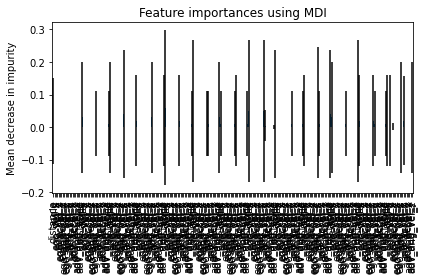

In [7]:
importances = RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF.estimators_], axis=0)
feature_names=x_test.columns.values.tolist()
forest_importances = pd.Series(importances, index=feature_names)

#print(np.sort(importances)[::-1])
sorted_importances = np.argsort(importances)[::-1]
sorted_tuple = [(i,feature_names[i],importances[i]) for i in sorted_importances]
print(sorted_tuple[:20])
print(len([x for x in sorted_tuple if x[2]==0])/len(sorted_tuple) * 100)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std,ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [43]:
RF.predict(x_test[:4])

array(['1', '0', '0', '1'], dtype=object)